In [3]:
from itertools import product, chain
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import sleep
from PIL import Image as Imag
import pyautogui
import pandas as pd
from copy import deepcopy

In [4]:
# Legal moves list
candy_all=['blue', 'red', 'green', 'violet', 'orange']

In [5]:
def closeButtonLookup():
    '''Looks for close button and presses it returns False if close button is not found, else - True'''
    if bool(pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7))==True:
        x, y = pyautogui.locateCenterOnScreen('Images/btn_close.png', confidence=0.7)
        pyautogui.click(x/2, y/2, duration=0.5, button='right')
        print('OK,I am out of here!')
        return True
    return False

In [6]:
class GameState():  
    '''Game state, board = dataframe, 'frm' and 'at' = lists of row/colum indices of the swapped candies'''
    def __init__(self,  board, parent=None, frm=None, at=None):
        self.board = board
        self.parent = parent
        self.frm = frm
        self.at = at
        self.score = 0
        self.super = False
        self.matches = list()
        self.children = list()

In [144]:
class Match():   
    '''Match contains info on size, position and type of candy'''  
    def __init__(self, typ, pos):
        self.size = pos.shape[0]
        self.pos = pos
        self.typ = typ
        obstacles = np.empty([1,1])

In [145]:
def find_match(selected):    
    '''Takes Series as an input, returns index of a match3 in the series if there is, else: None'''   
    match=[i for i in selected.index]
    diff = [1]+[i-j for j,i in zip(match[:-1], match[1:])]
    diff = np.absolute(np.array(diff)) 
    mask = diff == 1
    if selected[mask].size>=3:
        return list(selected[mask].index)
    return 

In [269]:
def move_to(global_board, fr, to):
    '''Takes a Dataframe, and two lists of row/col values, swaps values in specified cells. 
        Outputs resulting Data frame '''
    local_board=global_board.copy()
    local_board.loc[fr[0], fr[1]], local_board.loc[to[0], to[1]] = local_board.loc[to[0], to[1]], local_board.loc[fr[0], fr[1]]
    return local_board

In [270]:
def generate_children(global_board, pos):
    '''Generate gamestates from valid moves from a given tile, pos=list of row/col values.
    Return list of gamestates.'''
    global legal_tiles
    positions = np.array(pos)
    directions = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
    moves = np.add(positions, directions)
    # Filter the legal_tiles moves and save them in a children nodes attribute
    children=[]
    for move in moves:
        if tuple(move) in legal_tiles:
            local_board = move_to(global_board, pos, move)
#             display(local_board)
            m = GameState(local_board, None, frm=pos, at=move)
#             print(id(m.board))
            children.append(m)
    return children

In [271]:
def select_type(typ, board, ind=None, col=None):
    '''Select all instances of a given type in a Series = board.iloc[index, column] 
    where board is Pandas DataFrame. When calling the function one of the kwargs MUST be given in a call'''    
    if ind == None:
        ind=board.index, 
    if col == None:
        col=board.columns
    selected = board.loc[ind,col][board.loc[ind,col]==typ]
    if selected.size>=3:
        return selected
    return pd.Series(dtype='object')

In [502]:
def rake(series, start):
    '''Consider the column in a table with variety of values in each cell.
    We choose the start sell and 'rake' upwards as long as values stays the same,
    then downwhads on same condition, but this time saving the cells indices thus
    we get an array of matching values and its members positions in the column.
    Returns List on indices'''
    spec = series[start]
    match_indices = []
    upper_limit = None
    up = series[:start]
    while list(up):
        ind=up.index.max()
        sample = up.pop(ind)
        if sample == spec:
            upper_limit = ind
        if not sample == spec:
            break
    down = series[upper_limit:]
    while list(down):
        ind = down.index.min()
        sample = down.pop(ind)
        if sample == spec:
            match_indices.append(ind)
        if not sample == spec:
            break
    return match_indices

In [272]:
def pix_avg(pix_array):
    """Averages the RGB values of the pixel array. Returns vector of 3 values."""
    x = np.mean(pix_array, axis=1)
    y = np.ones(133)
    return np.matmul(x.T,y)/133

#### Get input for board height and width.

In [299]:
board_w = int(input('Borad width is:  '))

Borad width is:  5


In [300]:
board_h = int(input('Borad height is: '))

Borad height is: 5


In [301]:
tile_w = 138
tile_h = 133
tilesize = np.array([tile_h, tile_w])

In [302]:
screensize = pyautogui.size()

In [303]:
green = Imag.open('Images/candy_green.png')
violet = Imag.open('Images/candy_violet.png')
blue = Imag.open('Images/candy_blue.png')
orange = Imag.open('Images/candy_orange.png')
red = Imag.open('Images/candy_red.png')
obstacle = Imag.open('Images/obstacle_1.png')
bg = Imag.open('Images/bg.png')

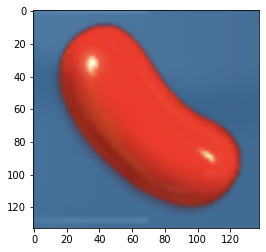

In [304]:
red=Imag.open('Images/candy_red.png')
red_array = np.array(red)
plt.imshow(red_array)
# # plt.imshow(red_array[12:133+12, 7:138+7])
# im=Imag.fromarray(red_array[12:133+12, 7:138+7])
# im.save(f'Images/candy_red.png')

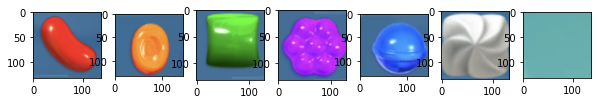

In [305]:
fig = plt.figure(figsize=(10, 7))
rows =1
columns =7
count=0
for im in [red, orange, green, violet, blue, obstacle, bg]:
    count+=1
    fig.add_subplot(rows, columns, count)
    plt.imshow(im)   

In [306]:
# Get mean RGB values
blue_mean = pix_avg(blue)
orange_mean = pix_avg(orange)
red_mean = pix_avg(red)
violet_mean = pix_avg(violet)
green_mean = pix_avg(green)
obstacle_mean = pix_avg(obstacle)
bg_mean = pix_avg(bg)

In [320]:
candy_rgb = pd.DataFrame(
    [green_mean, blue_mean, violet_mean, orange_mean, obstacle_mean, bg_mean],
    index =['green','blue','violet','orange','obstacle','bg']
    )

In [335]:
all_tiles = list(product(range(1, board_h+1),range(1, board_w+1)))

#### Create a dictionary of coordinates for mouse drags.

In [336]:
game_scr_size =  board_w * tile_w, board_h * tile_h
corner = screensize[1]*2 - game_scr_size[1]
tilecenters = {pos:(np.flip(np.array(pos)*tilesize+np.array([screensize[1]*2 - game_scr_size[1],0])+67)/2).astype(int) for pos in all_tiles}

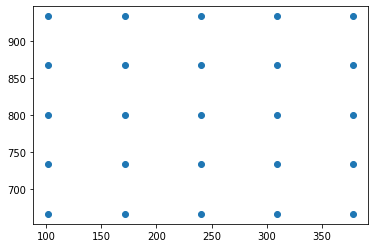

In [337]:
df = pd.DataFrame(tilecenters.values())
plt.scatter(df[0], df[1])

## Scan the game area, identify the cell contaiins.

In [340]:
t=pyautogui.screenshot('Images/board_ss.png',region=(10, corner, game_scr_size[0], game_scr_size[1]))

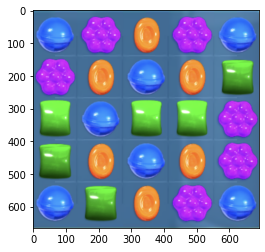

In [341]:
image = Imag.open("Images/board_ss.png")
# image = Imag.open("Images/board_ss.png")
image_array = np.array(image)
plt.imshow(image)

### Save BG tile

### Split game ss to tiles.

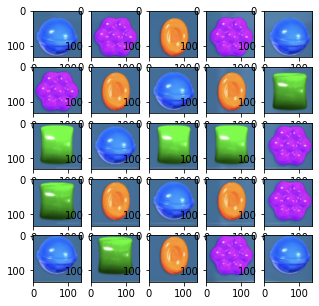

In [344]:
all_vals = []
fig = plt.figure(figsize=(board_w, board_h))
rows = board_h
columns = board_w
count=0  
for i in all_tiles:
    count+=1
    fig.add_subplot(rows, columns, count)
    starts = np.array(i)-1 
    ends = np.array(i)
    start = (starts * tilesize ).astype(int)
    end = (ends * tilesize).astype(int)
    all_vals.append(image_array[start[0]:end[0], start[1]:end[1]])
    plt.imshow(image_array[start[0]:end[0], start[1]:end[1]])

## Create a representation of the game board.

In [345]:
board = pd.DataFrame('0', index=range(board_h+2), columns=range(board_w+2))
Root = GameState(board)

In [346]:
for pos, array in zip(all_tiles, all_vals):
    error = np.matmul(np.abs(candy_rgb.to_numpy()-pix_avg(array).T), np.ones(4))
    typ = candy_rgb.index[np.argmin(error)]
    Root.board.loc[pos] = typ

In [347]:
Root.board

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0
1,0,blue,violet,orange,violet,blue,0
2,0,violet,orange,blue,orange,green,0
3,0,green,blue,green,green,violet,0
4,0,green,orange,blue,orange,violet,0
5,0,blue,green,orange,violet,blue,0
6,0,0,0,0,0,0,0


## Look for the matches

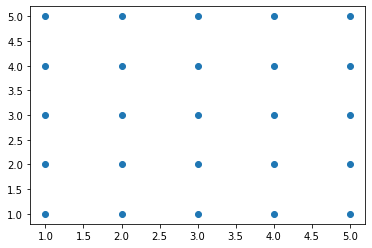

In [348]:
# legal_tiles: in the game only candies can move
legal_tiles = [tile for tile in all_tiles if Root.board.iloc[tile[0], tile[1]] in candy_all]
ar = np.array(legal_tiles)
plt.scatter(ar[:,1], ar[:,0])

In [154]:
candidates = list()

In [155]:
for tile in legal_tiles:
    candidates.extend(generate_children(Root.board.copy(), tile))

In [156]:
for cand in candidates:
    display(cand.board)

,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,blue,violet,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,green,blue,violet,green
1,violet,blue,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,blue,violet,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,violet,blue,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,green,violet
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,violet,blue,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,orange
1,violet,green,blue,violet,green
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,green,violet
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,green,green,blue,violet,orange
2,violet,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,green,violet,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,violet,blue,violet,orange
2,green,green,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,blue,green,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,green,blue,violet,green
1,violet,blue,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,green,violet,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,orange,violet,orange
2,green,violet,blue,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,violet,blue,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,blue,green,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,blue,orange
2,green,violet,orange,violet,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,orange,violet
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,violet,blue,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,blue
2,green,violet,orange,blue,orange
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,orange
1,violet,green,blue,violet,green
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,orange,violet
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,violet,green,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,green,green,blue,violet,orange
2,violet,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,blue,orange,blue,blue
3,green,violet,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,orange,violet,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,violet,blue,violet,orange
2,green,green,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,violet,green,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,green,blue,blue
3,green,blue,orange,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,blue,orange,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,orange,violet,orange
2,green,violet,blue,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,orange,violet,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,violet,blue
3,green,blue,green,blue,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,blue,orange
2,green,violet,orange,violet,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,blue,orange,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,green
3,green,blue,green,violet,blue
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,blue
2,green,violet,orange,blue,orange
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,blue,blue,green,violet,green
4,green,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,blue,green,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,green,green,violet,green
4,blue,blue,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,green,blue,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,blue,orange,blue,blue
3,green,violet,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,blue,green,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,blue,violet,green
4,blue,green,green,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,violet,green,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,green,blue,blue
3,green,blue,orange,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,green,blue,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,green,violet
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,violet,blue
3,green,blue,green,blue,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,violet,green,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,blue
4,blue,green,blue,violet,green


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,green
3,green,blue,green,violet,blue
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,green,violet
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,green,blue,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,blue,blue,green,violet,green
4,green,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,blue,green,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,green,green,violet,green
4,blue,blue,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,green,blue,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,violet,blue,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,blue,violet,green
4,blue,green,green,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,blue,green,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,blue,violet


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,violet,blue,blue


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,blue
4,blue,green,blue,violet,green


,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,blue,violet


### Look for matches in the resulting boards.

In [157]:
for candidate in candidates:
    # Column-wise
    # Get types of the match to look for.
    types=[]
    types.append(candidate.board.iloc[candidate.frm[0], candidate.frm[1]])
    types.append(candidate.board.iloc[candidate.at[0], candidate.at[1]])
    for typ in types:

        # Search the column for the values of the given type
        res_vert = {i : select_type(typ, candidate.board, col=i) for i in candidate.board.columns 
                    if select_type(typ, candidate.board, col=i).any()}

        # Now look for actual matches in the result of the search
        for key, val in res_vert.items():
                        match = find_match(val)
                        if match:
                            candidate.matches_vert.append( Match( val.all(), candidate.board.loc[match,key] ))
        # And row-wise
        res_horiz = {i : select_type(typ, candidate.board, ind=i) for i in candidate.board.index 
                     if select_type(typ, candidate.board, ind=i).any()}

        for key, val in res_horiz.items():
                        match = find_match(val)
                        if match:
                            candidate.matches_horiz.append( Match( val.all(), candidate.board.loc[key, match] ))

### Prune the children. Keep boards with matches, delete the rest.

In [158]:
# Choose candidates that have vertical matches:
vert_cands = [cand for cand in candidates if any(cand.matches_vert)]

In [159]:
# Choose candidates that have horizontal matches:
horiz_cands = [cand for cand in candidates if any(cand.matches_horiz)]

### Evaluate children

In [160]:
selected = []

In [161]:
# Look for double matches of the same type as they are likely to indicate super matches
# Select cadidates that have matches in both horiz and vert, check if both matches are same color.

In [162]:
# TODO: add bonus score for a sertain amount of certain type of candy.

In [163]:
# TODO: add score for obstacles in neighbouring board cells.

In [164]:
for gamestate in filter(lambda x: x in horiz_cands, vert_cands):
#     display(gamestate.board)
    if any([i.typ==j.typ for i in gamestate.matches_vert for j in gamestate.matches_horiz]):
        gamestate.super=True
    selected.append(gamestate)    

In [165]:
# Sum of all matches sizes in the GameState
def sum_score(instance):
    s = sum([match.size for match in instance.matches_horiz]) + sum(match.size for match in instance.matches_vert)   
    return s

In [166]:

if horiz_cands:
    main_candidate_horiz = max(horiz_cands, key=sum_score)
    if any([match.size>3 for match in main_candidate_horiz.matches_horiz]):
        main_candidate_horiz.super = True

    main_candidate_horiz.score += sum_score(main_candidate_horiz)
    selected.append(main_candidate_horiz)

In [167]:
 
if vert_cands:
    main_candidate_vert = max(vert_cands, key=sum_score)
    if any([match.size>3 for match in main_candidate_vert.matches_vert]):
        main_candidate_vert.super = True

    main_candidate_vert.score += sum_score(main_candidate_vert)
    selected.append(main_candidate_vert)

In [168]:
best = max(selected, key = lambda x: x.score)
best.board

,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,green,green,violet,green
4,blue,blue,blue,violet,blue


In [169]:
best.frm, best.at

((3, 1), array([4, 1]))

In [170]:
best.matches_vert

[]

In [171]:
best.matches_horiz[0].size

3

In [172]:
pyautogui.moveTo(tilecenters[best.frm][0], tilecenters[best.frm][1])

In [173]:
pyautogui.dragTo(tilecenters[tuple(best.at)][0], tilecenters[tuple(best.at)][1], button='right')

### TODO:
collapse matches: 
- create empty cells where matches are 
- move remaining candies to fill the space.

In [174]:
# screen size
pyautogui.size().height

900

In [175]:
Root.board

,0,1,2,3,4
0,violet,blue,blue,violet,green
1,violet,green,blue,violet,orange
2,green,violet,orange,blue,blue
3,green,blue,green,violet,green
4,blue,green,blue,violet,blue


In [176]:
Root.board.loc[:,4][Root.board[4]=='red'].index.max()

nan

In [177]:
Root.board.shift(-1).loc[[2, 3],4]

2    green
3     blue
Name: 4, dtype: object

In [178]:
Root.board[4][Root.board[4]=='obstacle'].shift(-1)

Series([], Name: 4, dtype: object)

In [497]:
Root.board

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0
1,0,blue,violet,orange,violet,blue,0
2,0,violet,orange,blue,orange,green,0
3,0,green,blue,green,green,violet,0
4,0,green,orange,blue,orange,violet,0
5,0,blue,green,orange,violet,blue,0
6,0,0,0,0,0,0,0


In [498]:
test2 = move_to(Root.board, [1, 3], [2, 3])

In [507]:
test2

,0,1,2,3,4,5,6
0,0,0,0,0,0,0,0
1,0,blue,violet,blue,violet,blue,0
2,0,violet,orange,orange,orange,green,0
3,0,green,blue,green,green,violet,0
4,0,green,orange,blue,orange,violet,0
5,0,blue,green,orange,violet,blue,0
6,0,0,0,0,0,0,0


In [ ]:
test3 = 

In [514]:
pos[0], pos[1]

(2, 3)

In [517]:
board.loc[2][3]

'orange'

In [518]:
'''Given a tile coordinates rake the grid column-vise and row-wize'''
board = test2
pos = 2, 3
matches = [rake(board.loc[pos[0]], pos[1]), rake(board.loc[:,pos[1]], pos[0])]
matches


[[2, 3, 4], []]

In [490]:
root=pd.DataFrame(np.zeros([5,5]).astype(int))

In [492]:
root.iloc[0,2]=1
root.iloc[2:5,2]=1
# root.loc[5]=np.nan
# root.loc[0,:]=np.nan

In [495]:
root
root.loc[[2, 3, 4],2]

2    1
3    1
4    1
Name: 2, dtype: int64

In [382]:
up=[-1,0]
down=[1,0]
start=[3,2]
spec=root.loc[start[0], start[1]]

### Testing!

In [506]:
dir()

['GameState',
 'Imag',
 'Image',
 'In',
 'Match',
 'Out',
 'Root',
 '_',
 '_100',
 '_101',
 '_102',
 '_103',
 '_105',
 '_106',
 '_108',
 '_109',
 '_111',
 '_114',
 '_116',
 '_121',
 '_122',
 '_123',
 '_124',
 '_125',
 '_127',
 '_128',
 '_129',
 '_13',
 '_130',
 '_133',
 '_134',
 '_135',
 '_136',
 '_138',
 '_140',
 '_141',
 '_142',
 '_143',
 '_146',
 '_147',
 '_148',
 '_149',
 '_15',
 '_150',
 '_156',
 '_157',
 '_158',
 '_159',
 '_160',
 '_161',
 '_162',
 '_163',
 '_164',
 '_167',
 '_168',
 '_169',
 '_17',
 '_170',
 '_171',
 '_172',
 '_173',
 '_176',
 '_178',
 '_179',
 '_180',
 '_181',
 '_185',
 '_186',
 '_187',
 '_188',
 '_189',
 '_19',
 '_190',
 '_191',
 '_192',
 '_193',
 '_195',
 '_196',
 '_198',
 '_199',
 '_200',
 '_202',
 '_204',
 '_206',
 '_208',
 '_209',
 '_21',
 '_210',
 '_211',
 '_213',
 '_217',
 '_22',
 '_221',
 '_222',
 '_223',
 '_224',
 '_225',
 '_227',
 '_23',
 '_230',
 '_231',
 '_232',
 '_233',
 '_234',
 '_235',
 '_236',
 '_237',
 '_238',
 '_240',
 '_243',
 '_244',
 '_246'